In [2]:
import numpy as np 
import math
from __future__ import division # Import this to divide floats in python 2
from scipy import optimize as opt # for optimization

#For plotting
from matplotlib.backends.backend_pdf import PdfPages


In [21]:
 #calculate differential stress
d = 9.2# grain size in microns
B = 2451 #2451 (Holyoke 2010) #3631 (Stipp and Tullis, 2003)
m = -1.26 # Stress exponent, from Stipp and Tullis (2003)?

#Create dictionary of flow law coefficients
flow_laws = {
    "KT84": {"A": 2.2E-6, "n": 2.7, "Q": 1.2E5},
    'GT95wm': {"A": 1.8E-8, "n": 4, "Q": 1.37E5},
    'J84': {"A": 2.88E-3, "n": 1.8, "Q": 1.51E5},
    'K89': {"A": 1.1E-6, "n": 2.7, "Q": 1.34E5},
    'HC82': {"A": 1.99E-2, "n": 1.8, "Q": 1.67E5},
    'LP92g': {"A": 6.6E-8, "n": 3.1, "Q": 1.35E5},
    'LP92a': {"A": 3.98E-10, "n": 4, "Q": 1.35E5},
    "H01":  {"A": 6.3E-12, "n": 4, "Q": 1.35E5}, 
    "RB04": {"A": 1.2E-5, "n": 2.97, "Q": 2.42E5}
    }

flow_laws['H01']['A']


6.3e-12

In [4]:
#Define some basic functions

def temp_conv(T, direction = "C2K"):  #Convert from C to Kelvin or vice versa
    if direction == "C2K":
        Tk = T+273.15
        return Tk
    elif direction == "K2C":
        Tc = T-273.15
        return Tc
    else:
        print('ERROR: Not a valid direction of conversion')

def pres_conv(Pmpa): #Convert from MPa to Pa
    Ppa = round(Pmpa*1.0E6)
    return Ppa

#Defining PT Condition calculators and depth simulator, 
#alternatively use a range of temperatures as a given depth and pressure

def pressure_calculator(depth, density): #depth in km, density in g/cm3
    g = 9.8 #gravity
    h = depth*1000 #converting to SI
    row = density*1000 #converting to SI
    pressure = (row*g*h)/1.0E6 # pressure in MPa
    return pressure 

def temperature_calculator(depth, geothermal_gradient): #km, C/km
    temp = geothermal_gradient*depth 
    return temp
    
def depth_simulator(depth_range, density=2.7, geothermal_gradient=30): #depth range in km
    depth_conds = []
    for dep in range(depth_range[0], depth_range[1]):
        ptc = (round(pressure_calculator(dep, density)), temperature_calculator(geothermal_gradient, dep)) 
        depth_conds.append(ptc)
    return depth_conds


In [5]:
#Create the shear zone class

class Shearzone():
    def __init__(self, grain_size, constant_b, exponent):
        self.constant_b = constant_b 
        self.grain_size = grain_size 
        self.exponent = exponent
    
    def calculate_differential_stress(self): 
        part = (math.log(self.grain_size)-math.log(self.constant_b))/self.exponent
        s = math.exp(part)
        return s

#Create grain size simulator
def simulate_grain_size(range_min, range_max):
    B = 2451 #2451 (holyoke 2010) #3631 (stipp 2003)
    m = -1.26 # 
    diffs = []
    for x in range(range_min,range_max):
        part = (math.log(x)-math.log(B))/m
        s = math.exp(part)
        diffs.append(s)
    return diffs 
      


In [6]:
#instantiating the class
shear_zone = Shearzone(grain_size=d, constant_b=B, exponent=m)
s = shear_zone.calculate_differential_stress()
print(s)

84.1480458373


In [7]:


#Using the depth simulator, imput a tuple of depths in km
simulator_results = depth_simulator((15, 20))
print(simulator_results)
    

#These values are ready to go into Fugacity calculations



[(397.0, 450), (423.0, 480), (450.0, 510), (476.0, 540), (503.0, 570)]


In [8]:
#Input my pressure values and calculate temperature
pressure = pres_conv(400)

t = temperature_calculator(15, 30) #depth, geothermal gradient
print(t)
temperature = temp_conv(t)
print(pressure, temperature)


450
(400000000.0, 723.15)


In [9]:
#This section was adapted from PS.js by Tony Withers, see http://publish.uwo.ca/~awither5/fugacity/index.htm 
#for online calculator.

# Create a blank array
PScoeff = np.zeros([10,10])

# Input coefficients into array
PScoeff[0][2]=0.24657688*math.pow(10,6)
PScoeff[0][3]=0.51359951*math.pow(10,2) 
PScoeff[1][2]=0.58638965*math.pow(10,0) 
PScoeff[1][3]=-0.28646939*math.pow(10,-2) 
PScoeff[1][4]=0.31375577*math.pow(10,-4) 
PScoeff[2][2]=-0.62783840*math.pow(10,1) 
PScoeff[2][3]=0.14791599*math.pow(10,-1) 
PScoeff[2][4]=0.35779579*math.pow(10,-3) 
PScoeff[2][5]=0.15432925*math.pow(10,-7) 
PScoeff[3][3]=-0.42719875*math.pow(10,0) 
PScoeff[3][4]=-0.16325155*math.pow(10,-4) 
PScoeff[4][2]=0.56654978*math.pow(10,4) 
PScoeff[4][3]=-0.16580167*math.pow(10,2) 
PScoeff[4][4]=0.76560762*math.pow(10,-1) 
PScoeff[5][3]=0.10917883*math.pow(10,0) 
PScoeff[6][0]=0.38878656*math.pow(10,13) 
PScoeff[6][1]=-0.13494878*math.pow(10,9) 
PScoeff[6][2]=0.30916564*math.pow(10,6)
PScoeff[6][3]=0.75591105*math.pow(10,1) 
PScoeff[7][2]=-0.65537898*math.pow(10,5) 
PScoeff[7][3]=0.18810675*math.pow(10,3) 
PScoeff[8][0]=-0.14182435*math.pow(10,14) 
PScoeff[8][1]=0.18165390*math.pow(10,9) 
PScoeff[8][2]=-0.19769068*math.pow(10,6)
PScoeff[8][3]=-0.23530318*math.pow(10,2)
PScoeff[9][2]=0.92093375*math.pow(10,5)
PScoeff[9][3]=0.12246777*math.pow(10,3)


#Create function to make coefficient table for each T condition.
#Input coefficients in array from Eq 4 of Pitzer and Sterner (1994).

cs = np.zeros([10]) # Create blank array
def coeff_table():
    for i in range(0, 10):
        cs[i]=PScoeff[i][0]*math.pow(temperature,-4)+PScoeff[i][1]*math.pow(temperature,-2)\
        +PScoeff[i][2]*math.pow(temperature,-1)\
        +PScoeff[i][3]+PScoeff[i][4]*temperature+PScoeff[i][5]*math.pow(temperature,2)
        
#Call this function    
coeff_table()


#Calculating equation of state and fugacity

#Solve Equation of state, Eq 2 of Pitzer and Sterner (1994)
#Returns pressure in Pa
def eos(T, V):
    den = 1/V
    R = 8314472
    var_num = cs[2]+2*cs[3]*den+3*cs[4]*math.pow(den,2)+4*cs[5]*math.pow(den,3)
    var_denom = math.pow((cs[1]+cs[2]*den+cs[3]*math.pow(den,2)+cs[4]*math.pow(den,3)+cs[5]*math.pow(den,4)),2)
    pressure=den+cs[0]*math.pow(den,2)-math.pow(den,2)*(var_num/var_denom)
    pressure= pressure + (cs[6]*math.pow(den,2)*math.exp(-cs[7]*den)+cs[8]*math.pow(den,2)*math.exp(-cs[9]*den))
    pressure = pressure*(R*T) #pressure in Pa
    return pressure

#Solve for fugacity, Eq 1 of Pitzer and Sterner (1994)
#Returns fugacity in MPa
def PSfug(P,T,V):
    den=1/V;
    R=8314472;
    quotient = cs[0]*den+(1/(cs[1]+cs[2]*den+cs[3]*math.pow(den,2)+cs[4]*math.pow(den,3)+cs[5]*math.pow(den,4))-1/cs[1])
    quotient-= cs[6]/cs[7]*(math.exp(-cs[7]*den)-1)
    quotient-= cs[8]/cs[9]*(math.exp(-cs[9]*den)-1)
    lnf=(math.log(den)+ quotient+P/(den*R*T))+math.log(R*T)-1
    return math.exp(lnf)/1e6 # fugacity in MPa


#Optimizing equation to solve for volume 
# def fun(v):
#     return eos(temperature, v)- pressure
# volume = opt.brentq(fun, 5, 30) #Volume in cc/mol

# print(temperature, pressure)

# #Calculate fugacity 
# fug = PSfug(pressure, temperature, volume)
# print(fug)


In [10]:
#Calculate fugacity for a single P,T condition

temperature = temp_conv(450) #Enter temperature in degrees C
pressure = pres_conv(400) #Enter pressure in MPa

coeff_table()

#Optimizing equation to solve for volume 
def fun(v):
    return eos(temperature, v)- pressure
volume = opt.brentq(fun, 5, 30) #Volume in cc/mol

#Calculate fugacity 
fug = PSfug(pressure, temperature, volume)
print(fug)


116.716517252


In [11]:
#Using the depth simulator, input a tuple of depths in km
simulator_results = depth_simulator((10, 20)) #Input range of depths as tuple
print(simulator_results)

#Calculate fugacity for each depth or temperature set in simulator
fugacity = [] #set empty fugacity list
for pressure, temperature in simulator_results:
    
    
    def fun(v): #optimize for each PT value in array
        return eos(temp_conv(temperature), v)-pres_conv(pressure) #converts units
    volume = opt.brentq(fun, 5, 30)
    #print(volume)#print volume to show variability
    
    #calculate fugacity for each PT value now that volume is optimized
    fug = PSfug(pres_conv(pressure), temp_conv(temperature), volume)
    fugacity.append(fug)
    
print(fugacity)

[(265.0, 300), (291.0, 330), (318.0, 360), (344.0, 390), (370.0, 420), (397.0, 450), (423.0, 480), (450.0, 510), (476.0, 540), (503.0, 570)]
[73.32065665485717, 81.29473182614085, 89.79888484406439, 98.1030276584143, 106.54153609969205, 115.50341790663366, 124.1845439191434, 133.389935698497, 142.27103916048623, 151.67985520346446]


In [12]:
#Calculate a range of fugacities from range of temperatures at constant pressure

#Set pressure, convert to Pa.
pressure = pres_conv(pressure_calculator(15, 2.7)) #Depth, density

#Set range of temperatures
temperature_range = range(300,602,25)
print(temperature_range)
temp_range = []
for t in temperature_range:
    tr = temp_conv(t)
    temp_range.append(tr)
    
print(temp_range)


#Calculate fugacity for each depth or temperature set in simulator
fugacity = [] #set empty fugacity list
for temperature in temp_range:
    
    coeff_table()#call coeff table for each temperature
    
    def fun(v): #optimize for each PT value in array
        return eos(temperature, v)-pressure
    volume = opt.brentq(fun, 5, 30)
       #print(volume)#print volume to show variability
    
    #calculate fugacity for each PT value now that volume is optimized
    fug = PSfug(pressure, temperature, volume)
    fugacity.append(fug)
    
print(fugacity)
type(temp_range)

[300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600]
[573.15, 598.15, 623.15, 648.15, 673.15, 698.15, 723.15, 748.15, 773.15, 798.15, 823.15, 848.15, 873.15]
[36.684537448542656, 46.95157218183018, 58.53053648312184, 71.31244436107873, 85.16349276746384, 99.93347440725162, 115.46316827812262, 131.5905097689665, 148.1555245720523, 165.00412028112981, 181.99088482899342, 198.98105893501182, 215.8518441949751]


list

In [69]:




temperature = np.array(temp_range) # made this into np array to be able to divide by float


def calculate_strain_rate(s, flow_law = 'H01'): #s is differential stress, defaults to using Hirth et al flow law
    e = (flow_laws[flow_law]['A']*np.power(s,flow_laws[flow_law]['n'])*np.power(fugacity,1)*np.exp(-flow_laws[flow_law]['Q']/(8.3144598*temperature)))
    return e

def calculate_slip_rate(e, w): #w: width in m, output of mm/yr
    width = w*1000
    v = width*31536000*e
    return v



#e = calculate_strain_rate(s, flow_law = 'H01')
#print(e)
#calculate_slip_rate(e, 30) ### output of mm/yr

#result = np.ndarray(shape=(len(flow_laws.keys()), len(e)), dtype=float)
e = []
v = []
for key in flow_laws.keys():
    #print(key)
    ei = calculate_strain_rate(s, flow_law=key)
    vi = calculate_slip_rate(ei, 30)
       #print(ei)
    ei = ei.tolist()
    e.append(ei)
       # print(vi)
    vi = vi.tolist()
    v.append(vi)

    
#     #v = calculate_slip_rate(e, 30)
#     #save = e
#     #print(e)
    



# for key in flow_laws.keys():
#     print(key)
#     e = calculate_strain_rate(s, flow_law=key)
#     v = calculate_slip_rate(e, 30)
#     print(e)
#     print(v)
    


temperature = temp_conv(temperature, direction="K2C")

import pprint


#pprint.pprint(v[1])
# pprint.pprint(v[5])
# flow_laws.keys()


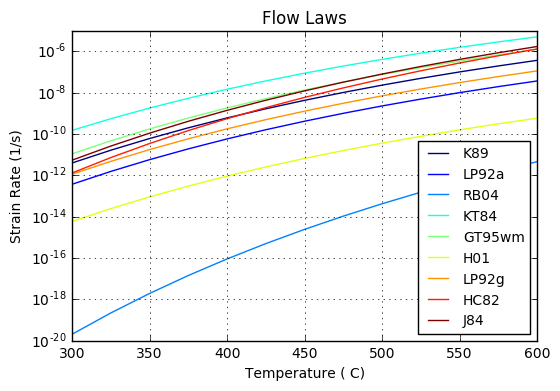

In [92]:
colors = iter(cm.jet(np.linspace(0, 1, len(e))))#set color ramp to jet with a line spacing of length e

plt.gca().set_yscale('log') #set y axis to log 
 
labels = []
# for key in flow_laws.keys():
#     l = key
#     labels.append(l)
#     for i in e:
#         plt.plot(temperature, e[i], color=next(colors))


for key in flow_laws.keys():
    l = key
    labels.append(l)

for i in range(0, len(e)):
    plt.plot(temperature, e[i], color=next(colors))

    
plt.xlabel('Temperature ( C)')
plt.ylabel('Strain Rate (1/s)')
plt.title('Flow Laws')
#for i in range(0, len(Tc)):
 #   plt.text(450,e[i][6],labels[i], fontsize=10, rotation = 8)
plt.legend(labels, fontsize=10, loc=4)
plt.grid()
plt.show()

pdf = PdfPages('StrainRates.pdf')
pdf.savefig(fig)
pdf.close()



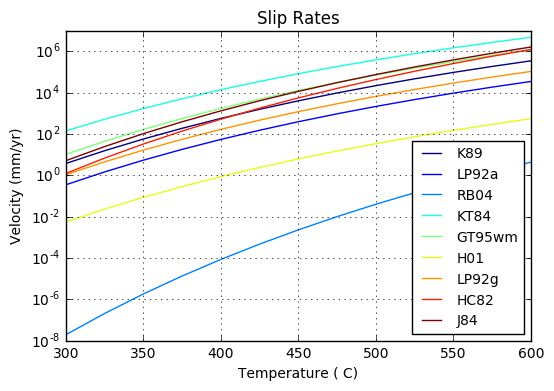

In [91]:


fig = plt.figure()

colors = iter(cm.jet(np.linspace(0, 1, len(v))))#set color ramp to jet with a line spacing of length e

plt.gca().set_yscale('log') #set y axis to log 
 
labels = []
for key in flow_laws.keys():
    l = key
    labels.append(l)

for i in range(0, len(v)):
    plt.plot(temperature, v[i], color=next(colors))

    
plt.xlabel('Temperature ( C)')
plt.ylabel('Velocity (mm/yr)')
plt.title('Slip Rates')
#for i in range(0, len(Tc)):
 #   plt.text(450,e[i][6],labels[i], fontsize=10, rotation = 8)
plt.legend(labels, fontsize=10, loc=4)
plt.grid()
plt.show()

pdf = PdfPages('SlipRates.pdf')
pdf.savefig(fig)
pdf.close()

#pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

In [1]:
#Double checking calculations

s = 84

T = temp_conv(450)

x = np.power(s,4)
y = np.power(300,1)
z = np.exp(-135000/(8.3144598*T))
e = 6.3E-12*x*y*z
v = 30000*31536000*e

#how to write a test!
def test_calculate_slip_rate():
    w = 30000
    e = 2.043722042401592e-11
    slip_rate = calculate_slip_rate(e, w)
    assert slip_rate == 19.335245498752982
test_calculate_slip_rate()

NameError: name 'temp_conv' is not defined

In [18]:
#%matplotlib nbagg

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from matplotlib import cm

#Define Constants
R = 8.3144598 #Gas constant
w = 30000 # (mm) shear zone width

#Define flow laws
FL = []#Paper, A, n, Q in that order
FL = [
      #['GT95wom', 0.00011, 4, 137000],
      ['KT84', 0.0000022, 2.7, 120000],
      ['GT95wm', 0.000000018, 4, 137000],
      ['J84', 0.00288, 1.8, 151000],
      ['K89', 0.0000011, 2.7, 134000],
      ['HC82', 0.0199, 1.8, 167000],
      ['LP92g', 0.000000066, 3.1, 135000],
      ['LP92a', 3.98E-10, 4, 135000],
      ['H01', 6.3E-12, 4, 135000],
      ['RB04',0.000012, 2.97, 242000]
      ]

#Set temperature range
Tc = []
for i in range(300, 602, 25):#min, max, step interval
    T = i
    Tc.append(T)
    
Tk = []
for i in range(len(Tc)): 
    T = temp_conv(Tc[i])#+273.15
    Tk.append(T)

#Calculate strain rate for all flow laws over temperature range, store in list
e = []
for j in range(0,len(flow_laws.keys())):
    f = []
    for i in range(0, len(Tk)):
        element = calculate_strain_rate(s, flow_law = flow_laws.keys()[i])#FL[j][1]*s**(FL[j][2])*math.exp(-FL[j][3]/(R*Tk[i]))#Flow law equation
        f.append(element)
        if len(f) == len(Tk):
            e.append(f)
            del f

#Include effect of water fugacity
F = np.power(117, 1)#-1.26) #MPa (Water Fugacity)
e = []
for j in range(0,len(FL)):
    f = []
    for i in range(0, len(Tk)):
        element = FL[j][1]*s**(FL[j][2])*F*math.exp(-FL[j][3]/(R*Tk[i]))#Flow law equation
        f.append(element)
        if len(f) == len(Tk):
            e.append(f)
            del f

#Calculate slip rate
V = []
for i in range(0, len(FL)):
    f = []
    for j in range(0, len(Tk)):
        element = w*31540000*e[i][j]#slip rate calculation
        f.append(element)
        if len(f) == len(Tk):
            V.append(f)
            del f

/Users/bmelosh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


IndexError: list index out of range

In [79]:
#Save figure to pdf
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('SlipRatesNEW.pdf') as pdf:
    pdf.savefig()  # saves the current figure into a pdf page

ValueError: No such figure: None

<IPython.core.display.Javascript object>


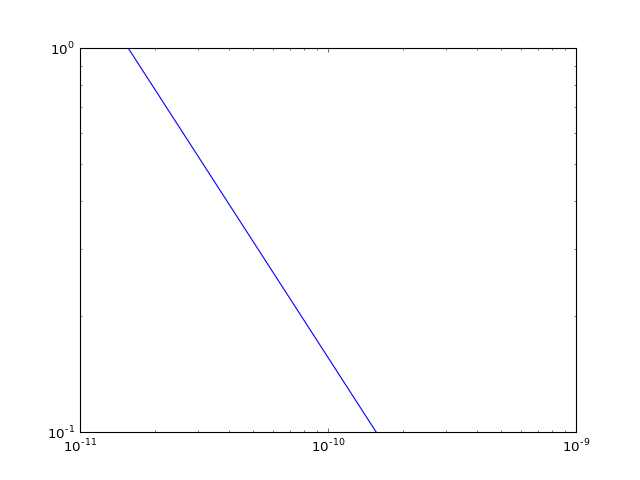

[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

In [656]:
# strain rate as a function of chaging widths
ehat = FL[7][1]*s**(FL[7][2])*F*math.exp(-FL[7][3]/(R*683.15))#Flow law equation (Hirth et al 2001)

sr = ehat*1000*31540000
w = [0.01]
st = []
strain = []
#np.linspace(0.0, 1.0, 21)int(1/0.05)
w = [i/100.0 for i in range(100, 1, -10)]#creates the range of widths of the shear zone chaging during folding

for i in range(0,len(w)):   
    f = sr/(w[i]*1000)#calculate strain rate fluctuation during changing widths
    st.append(f)
    f = st[i]/31540000
    strain.append(f)
#strain
#sr #mm/yr

strain
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.plot(strain, w)
w